In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**FETCH DATA WITH OPEN APIS

In [ ]:
pip install -U vnstock

In [ ]:
from vnstock import * #import all functions

**DATA STRUCTURE DEFINITION**

In [ ]:
def get_stock_vn_data(symbol, start, end):
    '''
    Get stock data in the given date range
    Inputs:
    symbol(str): stock symbol
    start(datetime): start date
    end(datetime): end date
    train_size(float): amount of data used for training
    Outputs:
    train_df, test_df OR df(if train_size=1)
    '''
    '''df = web.DataReader(symbol, 'yahoo', start, end)'''
    df = stock_historical_data(symbol=symbol, start_date=start, 
                               end_date=end, resolution="1D", type="stock", 
                               beautify=True, decor=False, source='DNSE')
    df['Adj Close'] = df['close']
    df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)
    return df

**IMPORT LIBRARES & BUILD THE DATASET**

Shape of the dataset : (61, 8)


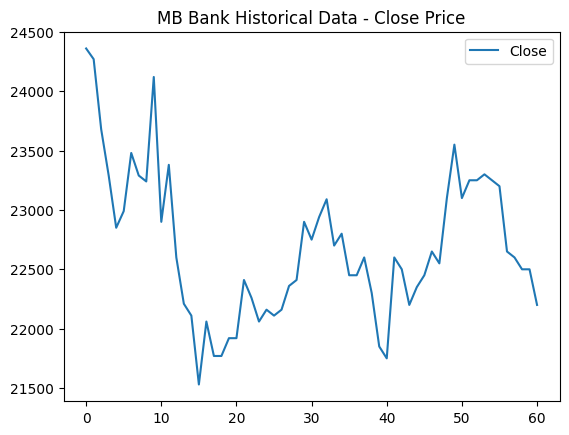

MBB  Stock Name: 
           Date   Open   High    Low  Close    Volume ticker  Adj Close
0   2024-04-01  24660  24710  24170  24360  19236200    MBB      24360
1   2024-04-02  24070  24270  23680  24270  28974400    MBB      24270
2   2024-04-03  24270  24270  23680  23680  22559800    MBB      23680
3   2024-04-04  23680  23730  23290  23290  27793500    MBB      23290
4   2024-04-05  23040  23240  22800  22850  25376700    MBB      22850
5   2024-04-08  22900  23290  22650  22990  24714800    MBB      22990
6   2024-04-09  22990  23480  22900  23480  15734800    MBB      23480
7   2024-04-10  23780  23830  23290  23290  21078100    MBB      23290
8   2024-04-11  22990  23340  22900  23240   9011600    MBB      23240
9   2024-04-12  23340  24170  23240  24120  23911200    MBB      24120
10  2024-04-15  23920  24510  22500  22900  47595100    MBB      22900
11  2024-04-16  22900  23380  22550  23380  32717500    MBB      23380
12  2024-04-17  23480  23530  22600  22600  23979900    MB

In [ ]:
# 1. Problem definition
"""
1. Problem definition
In the reinforcement learning framework for this case study, the algorithm takes an action (buy, sell, or hold)
depending on the current state of the stock price. The algorithm is trained using a deep Q-learning model to perform
the best action. The key components of the reinforcement learning framework are:

- Agent : Trading agent.
- Action : Buy, sell, or hold.
- Reward function : Realized profit and loss (PnL) is used as the reward function for this case study.
The reward depends on the action: sell (realized profit and loss), buy (no reward), or hold (no reward).
- State : A sigmoid function of the differences of past stock prices for a given time window is used as the state.
- Environment : Stock exchange or the stock market.
"""

# 2. Data loading and Python packages

# 2.1.1. Packages for reinforcement learning
import keras
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 2.1.2. Packages/modules for data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
import datetime
import math
from numpy.random import choice
import random
from collections import deque

# Diable the warnings
import warnings
warnings.filterwarnings('ignore')

# Display
set_option('display.width', 100)
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)

# 2.2. Loading the data.
"""
The fetched data for the time period of 04/2024 to 06/2024 is loaded:
"""
#dataset = read_csv('/content/drive/MyDrive/AutoStockTradeWithRL/data.csv', index_col=0)
#dataset = stock_historical_data(symbol="FPT", start_date="2021-01-01", end_date="2022-09-18", resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
start = "2024-04-01"
end = "2024-06-30"
stockName = "MBB"
dataset = get_stock_vn_data(stockName, start, end)
#print('Dataset type :', type(dataset))

# 3. Exploratory Data Analysis

# 3.1. Shape and description of data
#set_option('precision', 3)
#print(stockName, 'Data \n', dataset.tail())
#print('Description of dataset \n', dataset.describe())

# 3.2. Data visualization - close price
print('Shape of the dataset :', dataset.shape)
dataset['Close'].plot()
plt.title('MB Bank Historical Data - Close Price')
plt.legend()
plt.savefig('MB Bank Historical Data - Close Price')
plt.show()

print(stockName,' Stock Name: \n',dataset)

# 4. Data Preparation
# 4.1. Data Cleaning
"""
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column.
"""
# Checking for any null values and removing the null values
#print('Null Values =', dataset.isnull().values.any())

"""
In case there are null values fill the missing values with the last value available in the dataset.
"""
# Fill the missing values with the last value available in the dataset.
dataset = dataset.fillna(method='ffill')
#print(stockName,' Stock Name: \n',dataset)

**MODEL DEFINITION**

In [ ]:
# 5. Evaluate Algorithms and Models
# 5.1. Train Test Split
"""
For the train and test split, it's usually about using 80% of dataset to train the model and 20% for testing.
"""

X = list(dataset["Close"])
X = [float(x) for x in X]

validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

# 5.2. Implementation of the algorithm
"""
- Agent Class: An object of the agent class is created using the training phase and it's used for the training the model.
- Helper functions :
- Training module
"""

# 5.3. Agent class
"""
It consists of the following components:
• Constructor : init function with all important variables
• Function model
• Function act
• Function expReplay
"""


class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        # State size depends and is equal to the window size, n previous days
        self.state_size = state_size  # normalized previous days,
        self.action_size = 3  # hold, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        # self.epsilon_decay = 0.9

        # self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model() # The function model is a deep learning model
        # that maps the states to actions.

    # Deep Q Learning model- returns the q-value when given state as input
    def _model(self):
        model = Sequential()
        # Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        # Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        # Output Layer
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model

    """
     Return the action on the value function With probability (1-$\epsilon$) choose the action which has the highest
     Q-value.
     With probability ($\epsilon$) choose any action at random.
     Initially high epsilon-more random, later less
     The trained agents were evaluated by different initial random condition and an e-greedy policy with epsilon 0.05.
     This procedure is adopted to minimize the possibility of over-fitting during evaluation.
    """

# The function act returns an action given a state.
# It uses the model function and returns a buy, sell, or hold action:
    def act(self, state):
        # If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        # actions suggested.
        if not self.is_eval and random.random () <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        print("DEBUG OPTION",options)
        # set_trace()
        # action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

# The function expReplay is the key function, where the neural network is trained based on the observed experience.
    """
    This function implements the Experience replay mechanism, which stores a history of state, action, reward, and next
    state transitions that are experienced by the agent.
    """
    def expReplay(self, batch_size):
        mini_batch = []
        l = len ( self.memory )
        for i in range ( l - batch_size + 1, l ):
            mini_batch.append ( self.memory[i] )

        # the memory during the training phase.
        for state, action, reward, next_state, done in mini_batch:
            target = reward  # reward or Q at time t
            # update the Q table based on Q table equation
            # set_trace()
            if not done:
                # set_trace()
                # max of the array of the predicted.
                target = reward + self.gamma * np.amax ( self.model.predict ( next_state )[0] )

                # Q-value of the state currently from the table
            target_f = self.model.predict ( state )
            # Update the output Q table for the given action in the table
            target_f[0][action] = target
            # train and fit the model where state is X and target_f is Y, where the target is updated.
            self.model.fit ( state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 5.4 Helper functions
# prints formatted price


def formatPrice(n):
    return ("-" if n < 0 else "") + "{0:.2f}".format(abs(n) ) + " VND"

# # returns the vector containing stock data from a fixed file
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec


# returns the sigmoid
def sigmoid(x):
    if x < 0:
        return 1 - 1 / (1 + math.exp(x))
    else:
        return 1 / (1 + math.exp(-x))


# Returns an n-day state representation ending at time t
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    # block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])


# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buy signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Sell signal', markevery = states_sell)
    #plt.title('Total gains: %.2f' % profit, ' VND')
    plt.title(f'Total gains: {profit:.2f} VND')
    #plt.title('Total gains: %.2f' %, profit)
    plt.legend()
    plt.savefig('Total gains: %f'%(profit)+'.png')
    plt.show()



**TRAIN MODEL TRAINING AND SAVE FIT MODEL TO DRIVE**



Episode 0/10
Buy: 24270.00 VND
Buy: 23680.00 VND
Sell: 23290.00 VND | Profit: -980.00 VND
Buy: 22850.00 VND
Sell: 22990.00 VND | Profit: -690.00 VND
Sell: 23480.00 VND | Profit: 630.00 VND
Buy: 23240.00 VND
Buy: 22900.00 VND
1/1 [==============================] - 0s 21ms/step
Sell: 23380.00 VND | Profit: 140.00 VND
1/1 [==============================] - 0s 20ms/step
Buy: 22600.00 VND
1/1 [==============================] - 0s 23ms/step
Buy: 22110.00 VND
1/1 [==============================] - 0s 36ms/step
Sell: 21530.00 VND | Profit: -1370.00 VND
1/1 [==============================] - 0s 35ms/step
Sell: 21770.00 VND | Profit: -830.00 VND
1/1 [==============================] - 0s 35ms/step
Buy: 21920.00 VND
1/1 [==============================] - 0s 23ms/step
Buy: 22060.00 VND
1/1 [==============================] - 0s 35ms/step
DEBUG OPTION [[0.10774576 0.0499083  0.16124848]]
Sell: 22110.00 VND | Profit: 0.00 VND
1/1 [==============================] - 0s 30ms/step
Buy: 22360.00 VND
1/1 [=

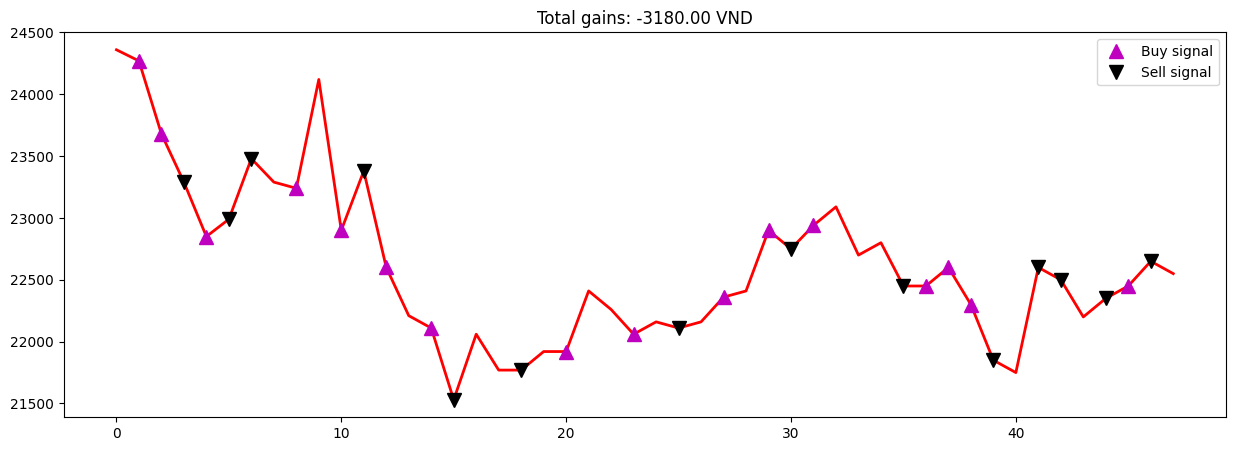

1/1 [==============================] - 0s 39ms/step
Episode 1/10
1/1 [==============================] - 0s 26ms/step
Buy: 24270.00 VND
1/1 [==============================] - 0s 30ms/step
Buy: 23680.00 VND
1/1 [==============================] - 0s 27ms/step
Sell: 23290.00 VND | Profit: -980.00 VND
1/1 [==============================] - 0s 22ms/step
Sell: 22850.00 VND | Profit: -830.00 VND
1/1 [==============================] - 0s 40ms/step
Buy: 23240.00 VND
1/1 [==============================] - 0s 26ms/step
DEBUG OPTION [[3.7750611 3.522066  5.484977 ]]
Sell: 24120.00 VND | Profit: 880.00 VND
1/1 [==============================] - 0s 25ms/step
Buy: 22900.00 VND
1/1 [==============================] - 0s 29ms/step
DEBUG OPTION [[4.449919  4.5596676 7.057629 ]]
Sell: 23380.00 VND | Profit: 480.00 VND
1/1 [==============================] - 0s 32ms/step
Buy: 22600.00 VND
1/1 [==============================] - 0s 23ms/step
Buy: 22210.00 VND
1/1 [==============================] - 0s 26ms/step

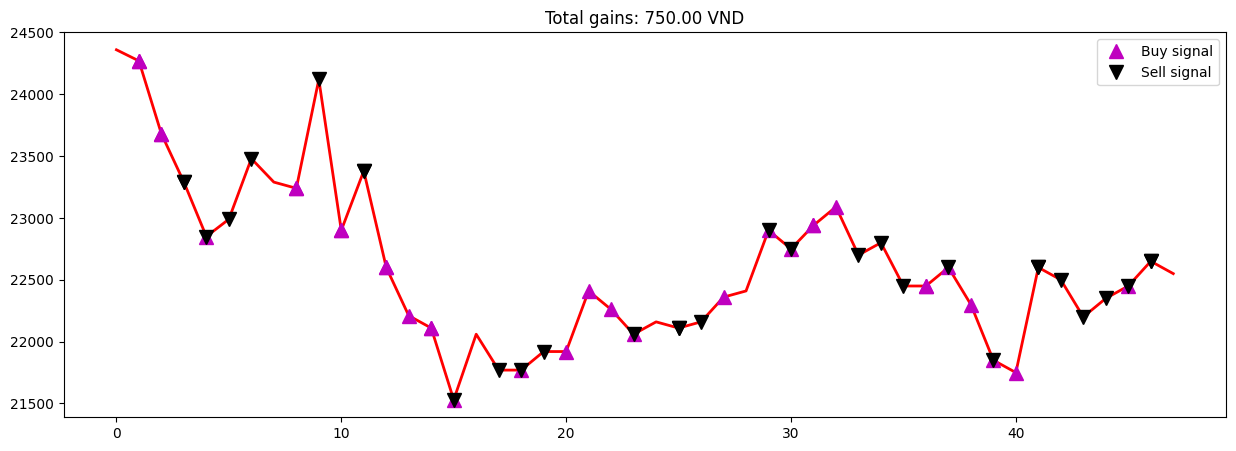

1/1 [==============================] - 0s 29ms/step
Episode 2/10
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[112.34279 126.6751  148.28297]]
1/1 [==============================] - 0s 33ms/step
Buy: 23290.00 VND
1/1 [==============================] - 0s 22ms/step
Sell: 22850.00 VND | Profit: -440.00 VND
1/1 [==============================] - 0s 22ms/step
Buy: 22990.00 VND
1/1 [==============================] - 0s 45ms/step
Sell: 23480.00 VND | Profit: 490.00 VND
1/1 [==============================] - 0s 27ms/step
Buy: 24120.00 VND
1/1 [==============================] - 0s 34ms/step
Buy: 22900.00 VND
1/1 [==============================] - 0s 23ms/step
Sell: 23380.00 VND | Profit: -740.00 VND
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[247.31828 265.41452 330.5203 ]]
Sell: 22210.00 VND | Profit: -690.00 VND
1/1 [==============================] - 0s 52ms/step
Buy: 21530.00 VND
1/1 [==============================] - 0s 21ms/step
Buy: 21770.00 VN

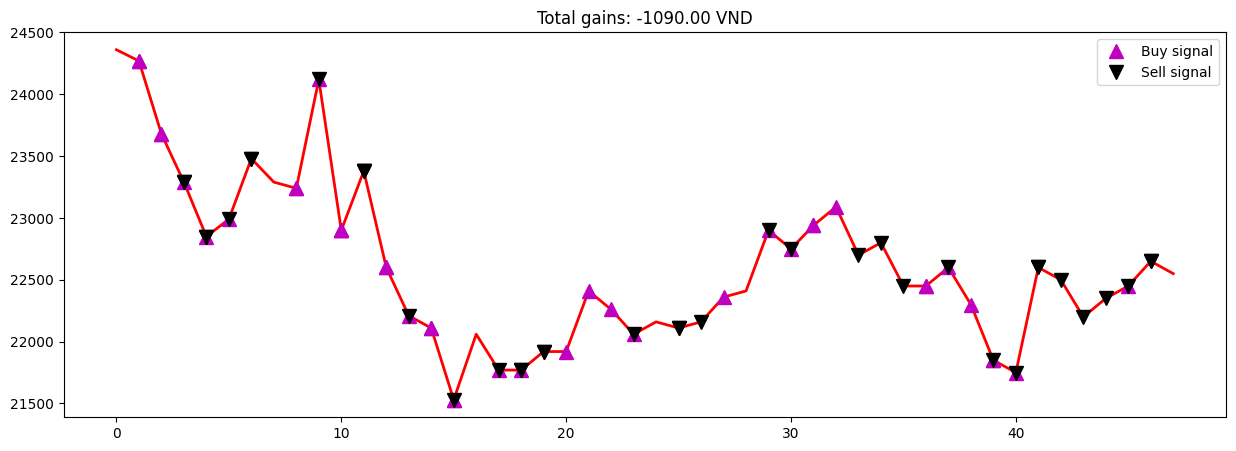

1/1 [==============================] - 0s 24ms/step
Episode 3/10
1/1 [==============================] - 0s 33ms/step
DEBUG OPTION [[260.8267  309.43185 314.37036]]
1/1 [==============================] - 0s 20ms/step
DEBUG OPTION [[256.23883 304.81412 308.04834]]
1/1 [==============================] - 0s 22ms/step
DEBUG OPTION [[252.65282 300.52478 302.00516]]
1/1 [==============================] - 0s 24ms/step
Buy: 22990.00 VND
1/1 [==============================] - 0s 37ms/step
Sell: 23290.00 VND | Profit: 300.00 VND
1/1 [==============================] - 0s 26ms/step
DEBUG OPTION [[239.11577 284.29935 280.33234]]
Buy: 23240.00 VND
1/1 [==============================] - 0s 23ms/step
DEBUG OPTION [[358.94977 427.95547 422.7023 ]]
Buy: 24120.00 VND
1/1 [==============================] - 0s 24ms/step
DEBUG OPTION [[238.74635 285.78104 282.44928]]
Buy: 22900.00 VND
1/1 [==============================] - 0s 21ms/step
DEBUG OPTION [[358.7488  429.90494 427.32092]]
Buy: 23380.00 VND
1/1 [===

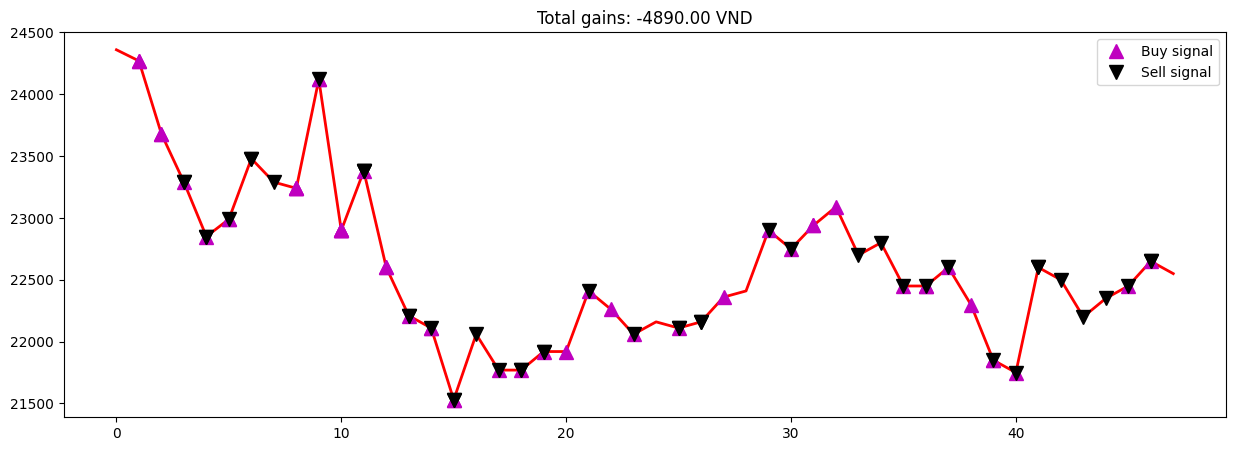

1/1 [==============================] - 0s 22ms/step
Episode 4/10
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[310.69284 359.21808 365.3779 ]]
1/1 [==============================] - 0s 22ms/step
DEBUG OPTION [[257.2366  295.193   303.65933]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[252.91005 287.209   299.66284]]
1/1 [==============================] - 0s 37ms/step
Buy: 22850.00 VND
1/1 [==============================] - 0s 21ms/step
DEBUG OPTION [[326.00665 357.46503 387.89014]]
Sell: 22990.00 VND | Profit: 140.00 VND
1/1 [==============================] - 0s 22ms/step
DEBUG OPTION [[320.46893 347.9512  381.07025]]
1/1 [==============================] - 0s 30ms/step
DEBUG OPTION [[234.0862  251.98677 278.2187 ]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[231.56482 247.25368 275.1087 ]]
1/1 [==============================] - 0s 36ms/step
Buy: 24120.00 VND
1/1 [==============================] - 0s 22ms/step
DEBUG OPTI

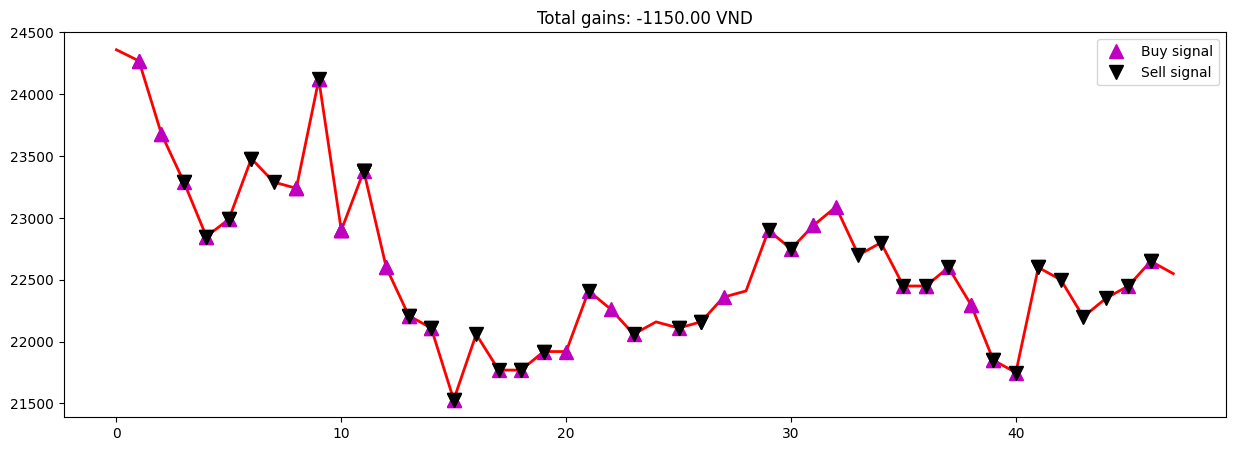

1/1 [==============================] - 0s 34ms/step
Episode 5/10
1/1 [==============================] - 0s 24ms/step
DEBUG OPTION [[239.93892 246.16096 260.92056]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[211.16422 216.77689 228.8786 ]]
1/1 [==============================] - 0s 21ms/step
DEBUG OPTION [[208.63582 214.30609 225.257  ]]
1/1 [==============================] - 0s 50ms/step
DEBUG OPTION [[205.77762 211.50938 221.1884 ]]
1/1 [==============================] - 0s 22ms/step
DEBUG OPTION [[247.09293 254.16742 263.52527]]
1/1 [==============================] - 0s 36ms/step
DEBUG OPTION [[243.78516 250.65674 258.69885]]
1/1 [==============================] - 0s 40ms/step
DEBUG OPTION [[235.81529 241.86655 246.59843]]
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[193.28166 197.9475  201.2973 ]]
1/1 [==============================] - 0s 29ms/step
DEBUG OPTION [[234.82262 239.93909 243.73315]]
1/1 [==============================] - 0s 25

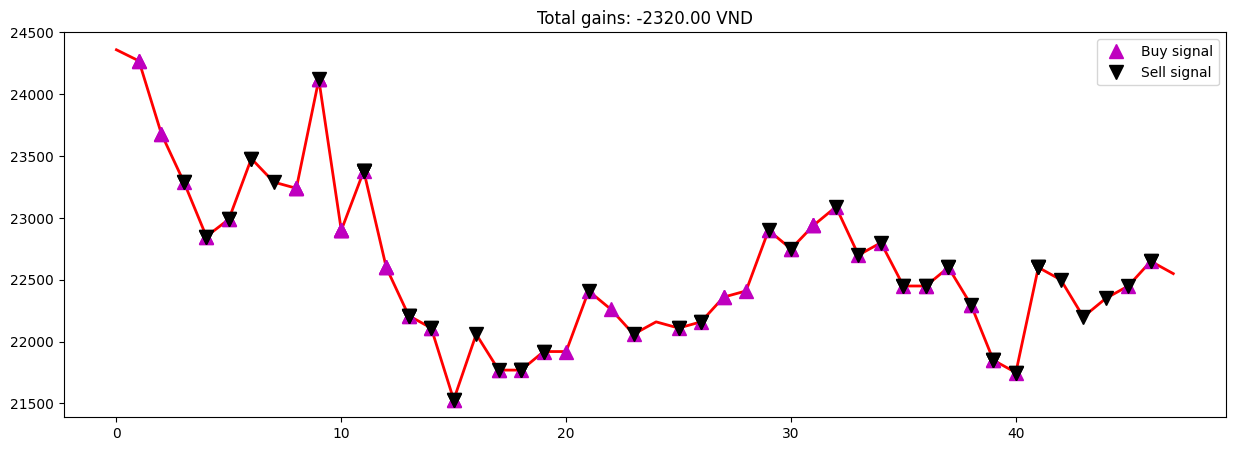

1/1 [==============================] - 0s 29ms/step
Episode 6/10
1/1 [==============================] - 0s 38ms/step
DEBUG OPTION [[266.4003  265.979   295.65143]]
1/1 [==============================] - 0s 23ms/step
DEBUG OPTION [[235.54109 235.12383 260.24976]]
1/1 [==============================] - 0s 39ms/step
DEBUG OPTION [[232.4779  232.01662 255.5227 ]]
1/1 [==============================] - 0s 37ms/step
DEBUG OPTION [[228.95721 228.48726 250.20317]]
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[225.69458 225.22748 245.32445]]
1/1 [==============================] - 0s 29ms/step
DEBUG OPTION [[216.89224 216.51517 232.44289]]
1/1 [==============================] - 0s 40ms/step
Buy: 23240.00 VND
1/1 [==============================] - 0s 37ms/step
DEBUG OPTION [[252.78864 253.49341 268.64655]]
Sell: 23380.00 VND | Profit: 140.00 VND
1/1 [==============================] - 0s 26ms/step
DEBUG OPTION [[209.70627 210.78053 222.71739]]
1/1 [============================

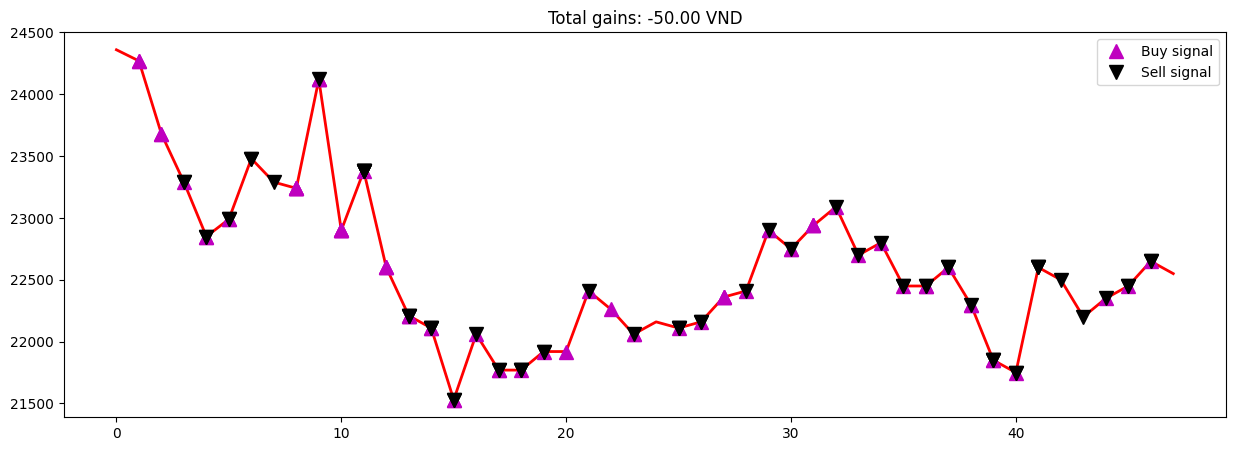

1/1 [==============================] - 0s 25ms/step
Episode 7/10
1/1 [==============================] - 0s 26ms/step
DEBUG OPTION [[203.23746 206.57883 214.28769]]
1/1 [==============================] - 0s 43ms/step
DEBUG OPTION [[201.63432 204.98033 212.08446]]
1/1 [==============================] - 0s 33ms/step
DEBUG OPTION [[199.74736 203.10321 209.50684]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[197.97232 201.33185 207.09459]]
1/1 [==============================] - 0s 23ms/step
DEBUG OPTION [[226.08813 229.88362 235.97458]]
1/1 [==============================] - 0s 28ms/step
DEBUG OPTION [[223.79617 227.57582 233.0155 ]]
1/1 [==============================] - 0s 36ms/step
DEBUG OPTION [[193.06657 196.43611 200.46898]]
1/1 [==============================] - 0s 40ms/step
DEBUG OPTION [[190.87991 194.29314 197.51978]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[188.76625 192.24854 194.72156]]
1/1 [==============================] - 0s 23

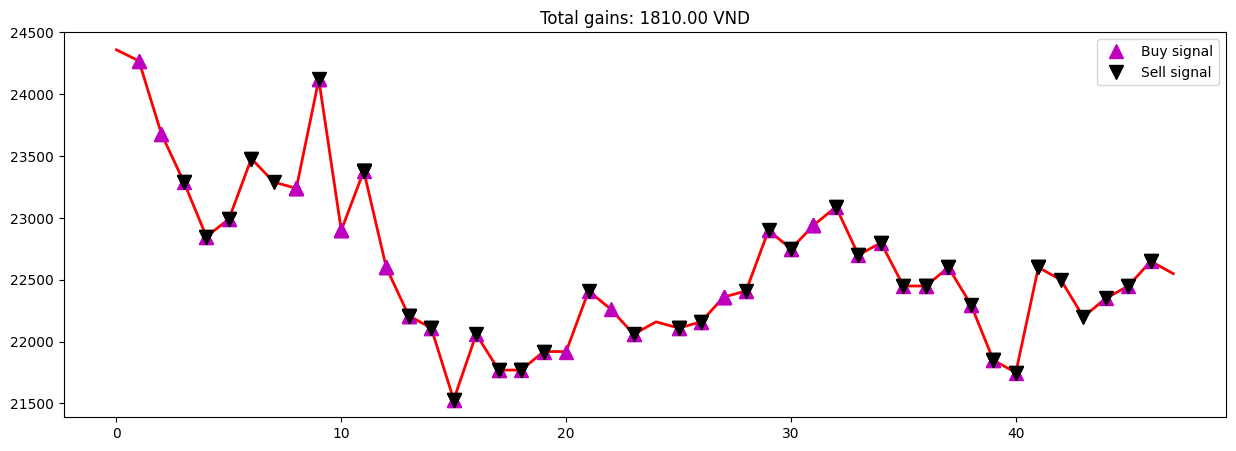

1/1 [==============================] - 0s 21ms/step
Episode 8/10
1/1 [==============================] - 0s 21ms/step
DEBUG OPTION [[398.14774 389.0482  479.9454 ]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[353.2795  345.33188 422.7697 ]]
1/1 [==============================] - 0s 47ms/step
DEBUG OPTION [[343.5047  335.94083 407.55865]]
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[333.2095  326.06198 391.73883]]
1/1 [==============================] - 0s 28ms/step
DEBUG OPTION [[324.06012 317.28394 377.82977]]
1/1 [==============================] - 0s 32ms/step
DEBUG OPTION [[367.197   359.63217 424.95752]]
1/1 [==============================] - 0s 49ms/step
DEBUG OPTION [[356.54138 349.36588 409.73166]]
1/1 [==============================] - 0s 29ms/step
DEBUG OPTION [[295.0028  289.35492 334.46893]]
1/1 [==============================] - 0s 33ms/step
DEBUG OPTION [[332.8354  326.1223  375.65573]]
1/1 [==============================] - 0s 29

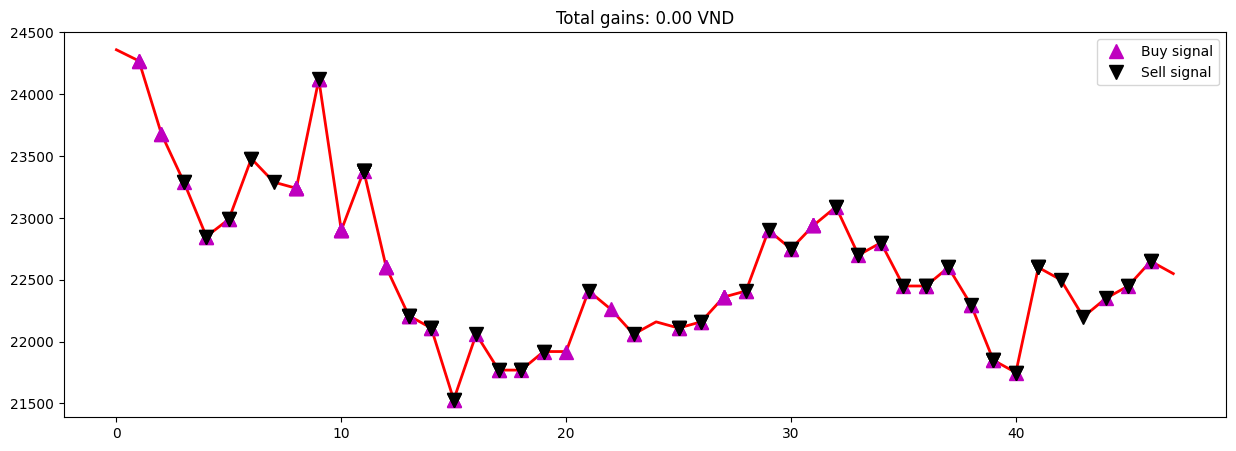

1/1 [==============================] - 0s 36ms/step
Episode 9/10
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[258.84445 248.2261  269.33176]]
1/1 [==============================] - 0s 28ms/step
DEBUG OPTION [[246.82648 234.14511 256.62134]]
1/1 [==============================] - 0s 27ms/step
DEBUG OPTION [[243.89192 228.15959 253.39108]]
1/1 [==============================] - 0s 22ms/step
DEBUG OPTION [[240.80173 222.03893 249.98314]]
1/1 [==============================] - 0s 32ms/step
DEBUG OPTION [[237.86337 216.25739 246.7624 ]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[248.99709 223.27983 258.1577 ]]
1/1 [==============================] - 0s 24ms/step
DEBUG OPTION [[245.47281 217.30421 254.34415]]
1/1 [==============================] - 0s 31ms/step
DEBUG OPTION [[229.93294 201.12581 238.0858 ]]
1/1 [==============================] - 0s 24ms/step
DEBUG OPTION [[224.90654 193.23567 232.28165]]
1/1 [==============================] - 0s 43

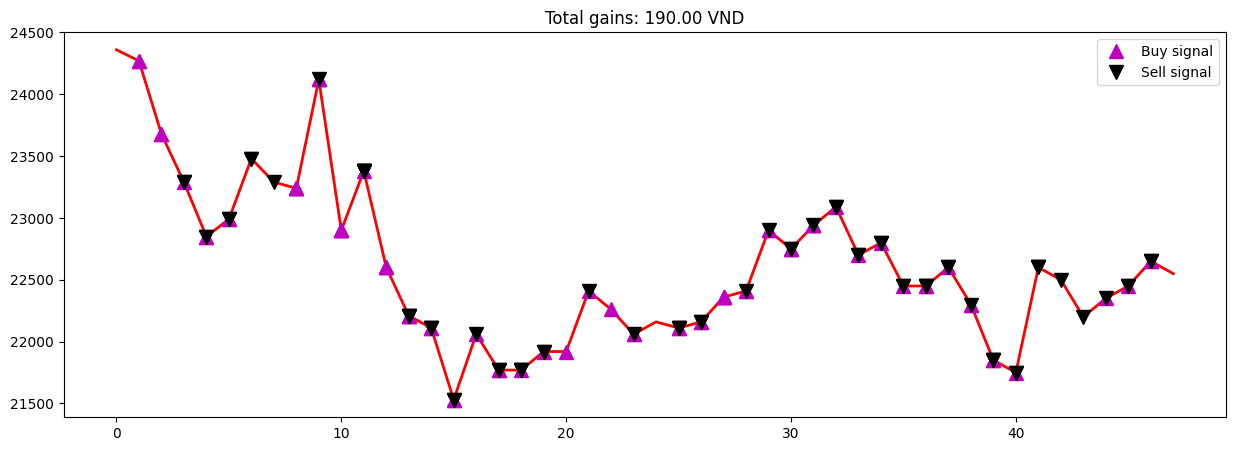

1/1 [==============================] - 0s 24ms/step
Episode 10/10
1/1 [==============================] - 0s 34ms/step
DEBUG OPTION [[214.58437 186.82217 217.2026 ]]
1/1 [==============================] - 0s 29ms/step
DEBUG OPTION [[208.55034 181.6545  210.51988]]
1/1 [==============================] - 0s 22ms/step
DEBUG OPTION [[206.08064 179.56964 207.34718]]
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[203.50082 177.3913  204.04512]]
1/1 [==============================] - 0s 37ms/step
DEBUG OPTION [[200.98311 175.26482 200.83487]]
1/1 [==============================] - 0s 32ms/step
DEBUG OPTION [[199.36473 173.99199 198.00597]]
1/1 [==============================] - 0s 27ms/step
Buy: 23290.00 VND
1/1 [==============================] - 0s 26ms/step
DEBUG OPTION [[191.348   167.61299 189.48375]]
1/1 [==============================] - 0s 42ms/step
DEBUG OPTION [[191.43416 168.06787 189.67612]]
1/1 [==============================] - 0s 44ms/step
DEBUG OPTION [[188.8

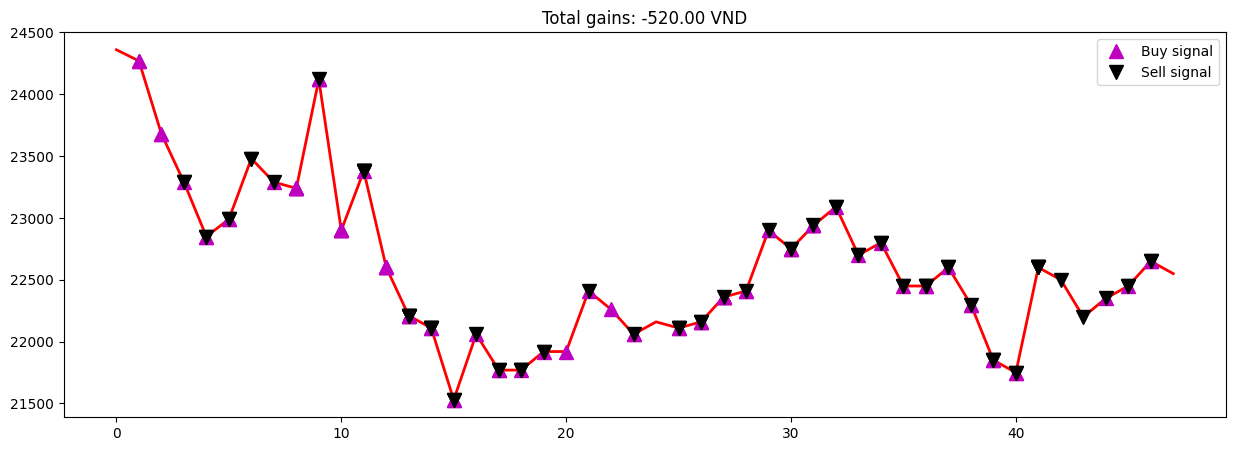

1/1 [==============================] - 0s 32ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 2499 (9.76 KB)
Trainable params: 2499 (9.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
window_size = 1
data = X_train
agent = Agent(window_size)
l = len(data) - 1
batch_size = 10
states_sell = []
states_buy = []
episode_count = 10


for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    # 1-get state
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []

    for t in range(l):
        # 2-apply best action
        action = agent.act(state)

        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t]))
        elif action == 2 and len(agent.inventory) > 0:  # sell
            bought_price = agent.inventory.pop(0)
            # 3: Get Reward
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        done = True if t == l - 1 else False
        # 4: get next state to be used in bellman's equation
        next_state = getState(data, t + 1, window_size + 1)
        # 5: add to the memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            # Chart to show how the model performs with the stock going up and down for each
            plot_behavior(data, states_buy, states_sell, total_profit)

        # 6: Run replay buffer function
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

    if e % 2 == 0:
        agent.model.save("/content/drive/MyDrive/MBB/model_ep" + str(e))


# Deep Q-Learning Model
print(agent.model.summary())



**SELECT & RUND THE DATA VALIDATION FOR FIT MODEL**

1/1 [==============================] - 0s 85ms/step
DEBUG OPTION [[221.73842 204.50569 237.19846]]
2
1/1 [==============================] - 0s 24ms/step
DEBUG OPTION [[214.02473 197.42429 228.93948]]
2
1/1 [==============================] - 0s 28ms/step
DEBUG OPTION [[214.02473 197.42429 228.93948]]
2
1/1 [==============================] - 0s 23ms/step
DEBUG OPTION [[214.02473 197.42429 228.93948]]
2
1/1 [==============================] - 0s 26ms/step
DEBUG OPTION [[214.02473 197.42429 228.93948]]
2
1/1 [==============================] - 0s 29ms/step
DEBUG OPTION [[229.4521  211.5871  245.45743]]
2
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[229.4521  211.5871  245.45743]]
2
1/1 [==============================] - 0s 24ms/step
DEBUG OPTION [[214.02473 197.42429 228.93948]]
2
1/1 [==============================] - 0s 25ms/step
DEBUG OPTION [[214.02473 197.42429 228.93948]]
2
1/1 [==============================] - 0s 23ms/step
DEBUG OPTION [[229.4521  211.5871  245.

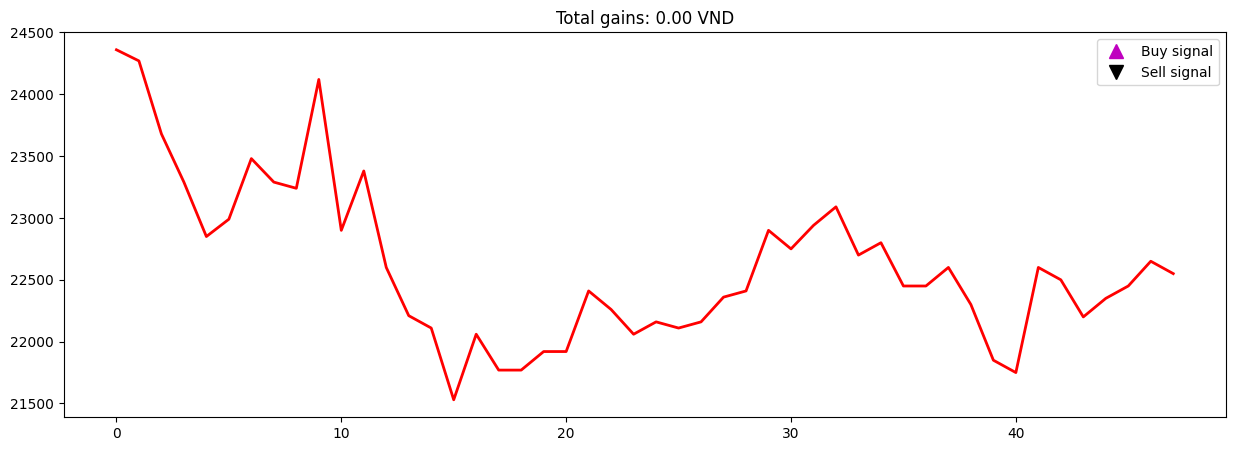

In [16]:
# 6. Testing the data
# agent is already defined in the training set above.
test_data = X_train
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
# Get the trained model
# model_name = "model_ep"+str(episode_count)
model_name = "/content/drive/MyDrive/MBB/model_ep10"
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

for t in range(l_test):
    action = agent.act(state)
    print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice (test_data[t]))

    elif action == 2 and len (agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        # reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)

Mounted at /content/drive
